# The Mathematical building blocks of NNs

## Imports

In [4]:
import tensorflow as tf
print(tf.__version__)

2.6.3


In [5]:
import numpy as np

from tensorflow.keras.datasets import mnist
from tensorflow import keras
from tensorflow.keras import  layers

import matplotlib.pyplot as plt
%matplotlib inline

## A first look at a NN

In [3]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data() 

In [9]:
print(f"{type(train_images) = }")
print(f"{train_images.shape = }")
print(f"{type(train_labels) = }")
print(f"{train_labels.shape = }")
print(f"{train_labels = }")
print("")
print(f"{type(test_images) = }")
print(f"{test_images.shape = }")
print(f"{type(test_labels) = }")
print(f"{test_labels.shape = }")
print(f"{test_labels = }")

type(train_images) = <class 'numpy.ndarray'>
train_images.shape = (60000, 28, 28)
type(train_labels) = <class 'numpy.ndarray'>
train_labels.shape = (60000,)
train_labels = array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

type(test_images) = <class 'numpy.ndarray'>
test_images.shape = (10000, 28, 28)
type(test_labels) = <class 'numpy.ndarray'>
test_labels.shape = (10000,)
test_labels = array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)


In [7]:
# define NN
model = keras.Sequential(
    [
        layers.Dense(512, activation="relu"),
        layers.Dense(10, activation="softmax"),
    ]
)

In [12]:
# compile
model.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [10]:
#prep
train_images = train_images.reshape((-1, 28 * 28))
train_images = train_images.astype("float32") / 255

test_images = test_images.reshape((-1, 28 * 28))
test_images = test_images.astype("float32") / 255


In [13]:
model.fit(train_images, train_labels, epochs=5, batch_size=128)

Epoch 1/5
469/469 [==============================] - 5s 9ms/step - loss: 0.2526 - accuracy: 0.9271
Epoch 2/5
469/469 [==============================] - 3s 7ms/step - loss: 0.1026 - accuracy: 0.9688
Epoch 3/5
469/469 [==============================] - 3s 7ms/step - loss: 0.0667 - accuracy: 0.9797
Epoch 4/5
469/469 [==============================] - 3s 7ms/step - loss: 0.0481 - accuracy: 0.9851
Epoch 5/5
469/469 [==============================] - 4s 8ms/step - loss: 0.0367 - accuracy: 0.9887


In [17]:
test_digits = test_images[0:8]
predictions = model.predict(test_digits)

In [22]:
predicted_clss = predictions.argmax(-1)

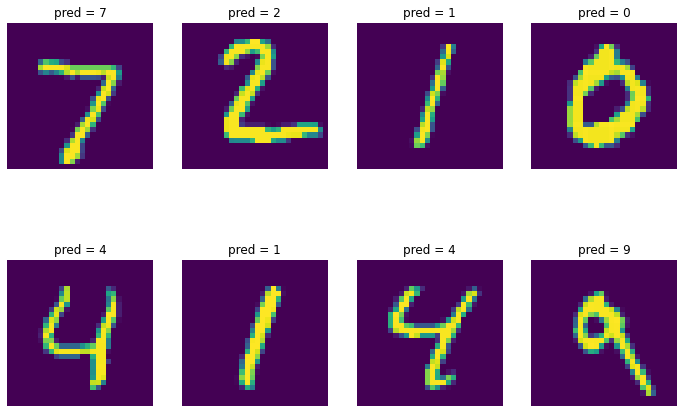

In [34]:
fig = plt.figure(figsize=(12, 8))

for i in range(8):
    img = test_digits[i]
    pred = predicted_clss[i]

    ax = fig.add_subplot(2, 4, i + 1)
    ax.imshow(img.reshape(28,28))
    ax.title.set_text(f"{pred = }")
    ax.set_axis_off()

plt.show()

In [46]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"{test_acc = :.4f}")

313/313 [==============================] - 1s 3ms/step - loss: 0.0689 - accuracy: 0.9785
test_acc = 0.9785


## Chaining derivates: The backprop algorithm

In [5]:
x = tf.Variable(0.)

with tf.GradientTape() as tape:
    y = 2 * x + 3

grad_of_y_wrt_x = tape.gradient(y, x)
print(f"{grad_of_y_wrt_x = }")

grad_of_y_wrt_x = <tf.Tensor: shape=(), dtype=float32, numpy=2.0>


In [6]:
x = tf.Variable(tf.random.uniform((2, 2)))

with tf.GradientTape() as tape:
    y = 2 * x + 3

grad_of_y_wrt_x = tape.gradient(y, x)
print(f"{grad_of_y_wrt_x = }")

grad_of_y_wrt_x = <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[2., 2.],
       [2., 2.]], dtype=float32)>


In [9]:
W = tf.Variable(tf.random.uniform((2, 2)))
b = tf.Variable(tf.zeros((2,)))
x = tf.random.uniform((2, 2))


with tf.GradientTape() as tape:
    y = tf.matmul(x, W) + b

grad_of_y_wrt_W_and_b = tape.gradient(y, [W, b])
print(f"{grad_of_y_wrt_W_and_b = }")

grad_of_y_wrt_W_and_b = [<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0.3804127, 0.3804127],
       [1.2618934, 1.2618934]], dtype=float32)>, <tf.Tensor: shape=(2,), dtype=float32, numpy=array([2., 2.], dtype=float32)>]


## Reimplementing out first example from scratch in TF

In [6]:
# output = activation( dot(input, W) + b)

class NaiveDense:
    def __init__(self, input_size, output_size, activation):
        self.activation = activation

        w_shape = (input_size, output_size)
        w_initial_value = tf.random.uniform(w_shape, minval=0, maxval=1e-1)
        self.W = tf.Variable(w_initial_value)

        b_shape = (output_size,)
        b_initial_value = tf.zeros(b_shape)
        self.b = tf.Variable(b_initial_value)

    def __call__(self, inputs):
        return self.activation(tf.matmul(inputs, self.W) + self.b)

    @property
    def weights(self):
        return [self.W, self.b]

In [7]:
def test_naive_dense():
    l = NaiveDense(10, 20, tf.nn.relu)

    random_input = tf.random.uniform((128, 10))

    l_out = l(random_input)

    w, b = l.weights
    expected_output = tf.maximum(random_input @ w + b, 0)

    assert (l_out == expected_output).numpy().all()

test_naive_dense()

In [8]:
class NaiveSequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, inputs):
        x = inputs
        for layer in self.layers:
            x = layer(x)
        return x

    @property
    def weights(self):
        return [w for layer in self.layers for w in layer.weights]

In [9]:
def test_naive_sequential():
    ls = NaiveSequential(
        [
            NaiveDense(10, 20, tf.nn.relu),
            NaiveDense(20, 5, tf.nn.relu),
        ]
    )

    random_input = tf.random.uniform((128, 10))

    ls_out = ls(random_input)

    w1, b1, w2, b2 = ls.weights

    x1 = tf.maximum(random_input @ w1 + b1, 0)
    expected_output = tf.maximum(x1 @ w2 + b2, 0)

    assert (ls_out == expected_output).numpy().all()

test_naive_sequential()

In [10]:
def get_batch_generator(images, labels, batch_size=128):
        assert len(images) == len(labels)

        for index in range(0, len(images), batch_size):
            batch_images = images[index: index + batch_size]
            batch_labels = labels[index: index + batch_size]
            yield batch_images, batch_labels


In [11]:
def test_batch_generator():
    batch_gen = get_batch_generator(np.arange(11), np.arange(11), batch_size=3)

    for batch_i, batch_l in batch_gen:
        print(f"{batch_i = }")
        print(f"{batch_l = }")
        print("")

test_batch_generator()

batch_i = array([0, 1, 2])
batch_l = array([0, 1, 2])

batch_i = array([3, 4, 5])
batch_l = array([3, 4, 5])

batch_i = array([6, 7, 8])
batch_l = array([6, 7, 8])

batch_i = array([ 9, 10])
batch_l = array([ 9, 10])



In [12]:
LR = 1e-3

def update_weights(gradients, weights):
    """plain SGD step"""
    for g, w in zip(gradients, weights):
        w.assign_sub(g * LR)

In [21]:
def test_update_weights():
    # get random model
    model = NaiveSequential(
        [
            NaiveDense(10, 20, tf.nn.relu),
            NaiveDense(20, 5, tf.nn.relu),
        ]
    )

    # get random input and targets
    random_input = tf.random.uniform((128, 10))
    random_target = tf.random.uniform((128, 5))
    loss_f = tf.keras.losses.mean_squared_error

    # forward pass and compute gradients
    with tf.GradientTape() as tape:
        predictions = model(random_input)
        per_sample_losses = loss_f(random_target, predictions)
        average_loss = tf.reduce_mean(per_sample_losses)

    gradients = tape.gradient(average_loss, model.weights)

    # optimizer step
    update_weights(gradients, model.weights)

    # check loss improves
    new_predictions = model(random_input)
    new_per_sample_losses = loss_f(random_target, new_predictions)
    new_average_loss = tf.reduce_mean(new_per_sample_losses)

    assert new_average_loss < average_loss


test_update_weights()

In [22]:
def training_step(model, batch_images, batch_labels, loss_f):
    # forward pass and compute gradients
    with tf.GradientTape() as tape:
        predictions = model(batch_images)
        per_sample_losses = loss_f(batch_labels, predictions)
        average_loss = tf.reduce_mean(per_sample_losses)

    gradients = tape.gradient(average_loss, model.weights)
    update_weights(gradients, model.weights)

    return average_loss

In [23]:
def test_training_step():
    # get random model
    model = NaiveSequential(
        [
            NaiveDense(10, 20, tf.nn.relu),
            NaiveDense(20, 5, tf.nn.relu),
        ]
    )

    # get random input and targets
    random_input = tf.random.uniform((128, 10))
    random_target = tf.random.uniform((128, 5))
    loss_f = tf.keras.losses.mean_squared_error

    # training step
    loss = training_step(model, random_input, random_target, loss_f)
    for _ in range(10):
        new_loss = training_step(model, random_input, random_target, loss_f)

        # check loss improves
        assert new_loss < loss


test_training_step()   

In [28]:
def fit(model, images, labels, *, epochs, loss_f, batch_size=128):
    for epoch in range(epochs):
        print(f"{epoch = }")
        batch_generator = get_batch_generator(images, labels)

        for batch_i, (batch_images, batch_labels) in enumerate(batch_generator):
            loss = training_step(model, batch_images, batch_labels, loss_f)

            if batch_i % 100 == 0:
                print(f"\t{batch_i = }: {loss.numpy() = }")

In [29]:
# get data
(train_images, train_labels), (test_images, test_labels) = mnist.load_data() 

#prep
train_images = train_images.reshape((-1, 28 * 28))
train_images = train_images.astype("float32") / 255

test_images = test_images.reshape((-1, 28 * 28))
test_images = test_images.astype("float32") / 255

# get model
model = NaiveSequential(
    [
        NaiveDense(28 * 28, 512, activation=tf.nn.relu),
        NaiveDense(512, 10, activation=tf.nn.softmax),
    ]
)


In [30]:
# train
fit(model, train_images, train_labels, epochs=5, loss_f=tf.losses.sparse_categorical_crossentropy)

epoch = 0
	batch_i = 0: loss.numpy() = 4.4671254
	batch_i = 100: loss.numpy() = 2.2328553
	batch_i = 200: loss.numpy() = 2.2252636
	batch_i = 300: loss.numpy() = 2.107552
	batch_i = 400: loss.numpy() = 2.210085
epoch = 1
	batch_i = 0: loss.numpy() = 1.9298022
	batch_i = 100: loss.numpy() = 1.8736537
	batch_i = 200: loss.numpy() = 1.8420581
	batch_i = 300: loss.numpy() = 1.7289224
	batch_i = 400: loss.numpy() = 1.8202466
epoch = 2
	batch_i = 0: loss.numpy() = 1.6024339
	batch_i = 100: loss.numpy() = 1.5763326
	batch_i = 200: loss.numpy() = 1.5169283
	batch_i = 300: loss.numpy() = 1.4394305
	batch_i = 400: loss.numpy() = 1.5089933
epoch = 3
	batch_i = 0: loss.numpy() = 1.3403506
	batch_i = 100: loss.numpy() = 1.3415992
	batch_i = 200: loss.numpy() = 1.2544831
	batch_i = 300: loss.numpy() = 1.2256455
	batch_i = 400: loss.numpy() = 1.2820411
epoch = 4
	batch_i = 0: loss.numpy() = 1.1394812
	batch_i = 100: loss.numpy() = 1.1605272
	batch_i = 200: loss.numpy() = 1.0601858
	batch_i = 300: los

In [31]:
# evaluate our naive model

predictions = model(test_images)
predicted_labels = np.argmax(predictions.numpy(), axis=1)

accuracy = (predicted_labels == test_labels).mean()
print(f"{accuracy = }")

accuracy = 0.7624
